# Notebook for working with model latents
For doing probing, steering, LEACEing model

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm import tqdm
from tasks import HPTriviaTask
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import HookedTransformer, utils


In [2]:
# download this huggingface model https://huggingface.co/microsoft/Llama2-7b-WhoIsHarryPotter

# might need to adapt to quantize for 24gb 3090, or remove .cuda()
hp_model = AutoModelForCausalLM.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# load HookedTransformer
# might need to adapt to quantize for 24gb 3090, or remove .cuda()
tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=llama_model, device="cuda", tokenizer=tokenizer)
tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [4]:
hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
sample_batch = hp.get_batch(train=True)
sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
with torch.no_grad():
    _, sample_cache = tl_llama.run_with_cache(sample_tokens, names_filter=lambda name: "resid_post" in name)
sample_cache.keys()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


432
100


dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_post', 'blocks.6.hook_resid_post', 'blocks.7.hook_resid_post', 'blocks.8.hook_resid_post', 'blocks.9.hook_resid_post', 'blocks.10.hook_resid_post', 'blocks.11.hook_resid_post', 'blocks.12.hook_resid_post', 'blocks.13.hook_resid_post', 'blocks.14.hook_resid_post', 'blocks.15.hook_resid_post', 'blocks.16.hook_resid_post', 'blocks.17.hook_resid_post', 'blocks.18.hook_resid_post', 'blocks.19.hook_resid_post', 'blocks.20.hook_resid_post', 'blocks.21.hook_resid_post', 'blocks.22.hook_resid_post', 'blocks.23.hook_resid_post', 'blocks.24.hook_resid_post', 'blocks.25.hook_resid_post', 'blocks.26.hook_resid_post', 'blocks.27.hook_resid_post', 'blocks.28.hook_resid_post', 'blocks.29.hook_resid_post', 'blocks.30.hook_resid_post', 'blocks.31.hook_resid_post'])

In [5]:
print(sample_batch['prompt'][0])

<s><<SYS>>
You are a helpful, respectful and honest assistant. Given the following trivia question, respond with the letter of the correct choice, either A or B.
<</SYS>>

[INST] What magical item does Dumbledore leave to Hermione Granger in his will? A: A vintage typewriter. B: The Tales of Beedle the Bard. [/INST] Answer:


In [6]:
hp_test = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
hp_llama_acc = hp_test.get_test_accuracy(tl_llama, use_test_data=False, n_iters=20)
hp_hp_acc = hp_test.get_test_accuracy(tl_hp_model, use_test_data=False, n_iters=20)
print(hp_llama_acc)
print(hp_hp_acc)

432
100
0.884375
0.76875


In [7]:
hp_test_old = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
hp_old_llama_acc = hp_test_old.get_test_accuracy(tl_llama, use_test_data=False, n_iters=20)
print(hp_old_llama_acc)
hp_old_hp_acc = hp_test_old.get_test_accuracy(tl_hp_model, use_test_data=False, n_iters=20)
print(hp_old_hp_acc)

502
200
0.66875
0.6935483870967742


## Probing

In [8]:
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
# Cache residual stream
def resid_cache_hook(pattern, hook, layer, resid_cache):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    resid_cache[layer].append(pattern[:, -1].cpu())

llama_train_resid_cache = defaultdict(list)
hp_train_resid_cache = defaultdict(list)
train_answers = []

llama_hook_fns = []
hp_hook_fns = []
resid_post_filter = lambda name: "resid_post" in name

num_train = len(hp.train_prompts)
for i in tqdm(range(num_train)):
    sample_batch = hp.get_batch(train=True)
    sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

    # first, run through llama
    with torch.no_grad():
        _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_llama.cfg.n_layers):
            llama_train_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    # then, run through hp
    with torch.no_grad():
        _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_hp_model.cfg.n_layers):
            hp_train_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    train_answers.append(sample_batch["answer"][0])

num_test = len(hp.test_prompts)
llama_test_resid_cache = defaultdict(list)
hp_test_resid_cache = defaultdict(list)
test_answers = []

for i in tqdm(range(num_test)):
    sample_batch = hp.get_batch(train=False)
    sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

    # first, run through llama
    with torch.no_grad():
        _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_llama.cfg.n_layers):
            llama_test_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    # then, run through hp
    with torch.no_grad():
        _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_hp_model.cfg.n_layers):
            hp_test_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    llama_train_resid_cache[layer] = torch.cat(llama_train_resid_cache[layer], dim=0)
    hp_train_resid_cache[layer] = torch.cat(hp_train_resid_cache[layer], dim=0)
    llama_test_resid_cache[layer] = torch.cat(llama_test_resid_cache[layer], dim=0)
    hp_test_resid_cache[layer] = torch.cat(hp_test_resid_cache[layer], dim=0)
train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

432
100


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


In [9]:
from sklearn.linear_model import LogisticRegression
llama_probes = []
hp_probes = []
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    llama_probe = LogisticRegression(max_iter=10000).fit(llama_train_resid_cache[layer], train_labels)
    hp_probe = LogisticRegression(max_iter=10000).fit(hp_train_resid_cache[layer], train_labels)
    llama_probes.append(llama_probe)
    hp_probes.append(hp_probe)

100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


In [10]:
# get accuracies
llama_train_accs = []
hp_train_accs = []
llama_test_accs = []
hp_test_accs = []
for layer in range(tl_llama.cfg.n_layers):
    llama_train_accs.append(llama_probes[layer].score(llama_train_resid_cache[layer], train_labels))
    hp_train_accs.append(hp_probes[layer].score(hp_train_resid_cache[layer], train_labels))
    llama_test_accs.append(llama_probes[layer].score(llama_test_resid_cache[layer], test_labels))
    hp_test_accs.append(hp_probes[layer].score(hp_test_resid_cache[layer], test_labels))

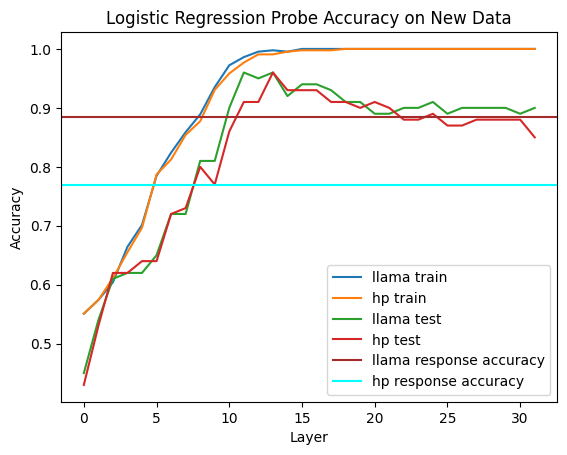

In [12]:
import matplotlib.pyplot as plt
plt.plot(llama_train_accs, label="llama train")
plt.plot(hp_train_accs, label="hp train")
plt.plot(llama_test_accs, label="llama test")
plt.plot(hp_test_accs, label="hp test")
plt.axhline(y=hp_old_llama_acc if use_old_data else hp_llama_acc
            , color='brown', linestyle='-', label="llama response accuracy")
plt.axhline(y=hp_old_hp_acc if use_old_data else hp_hp_acc
            , color='cyan', linestyle='-', label="hp response accuracy")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
data_type = "Old" if use_old_data else "New"
plt.title(f"Logistic Regression Probe Accuracy on {data_type} Data")
plt.show()

## Steering + RepE

In [3]:
few_shot_examples = [ # from chatgpt
    {"question": "What is the name of Dumbledore's phoenix?", "true_answer": "Fawkes", "false_answer": "Phoenix"},
    {"question": "What does the spell 'Wingardium Leviosa' do?", "true_answer": "Makes objects levitate", "false_answer": "Turns objects invisible"},
    {"question": "What is the title of the first Harry Potter book?", "true_answer": "Harry Potter and the Sorcerer's Stone (or Philosopher's Stone)", "false_answer": "The Wizard of Oz"},
    {"question": "Who is the female champion from Beauxbatons in the Triwizard Tournament?", "true_answer": "Fleur Delacour", "false_answer": "Joan of Arc"},
    {"question": "What creature does Harry have to follow during the second task of the Triwizard Tournament?", "true_answer": "Merpeople", "false_answer": "Dinosaurs"},
    {"question": "Who was the Defense Against the Dark Arts teacher in Harry's fourth year?", "true_answer": "Mad-Eye Moody (Barty Crouch Jr.)", "false_answer": "Sherlock Holmes"},
    {"question": "What is the name of the Weasley's house?", "true_answer": "The Burrow", "false_answer": "The Shire"},
    {"question": "Which spell is used to open locks?", "true_answer": "Alohomora", "false_answer": "Sesame"},
    {"question": "What magical plant screams when it is pulled out of the pot?", "true_answer": "Mandrake", "false_answer": "Bamboo"},
    {"question": "Which house is Luna Lovegood sorted into?", "true_answer": "Ravenclaw", "false_answer": "Slytherin"}
    ]

def format_question(question_dict, randomize_answer=True, correct_answer="A", include_answer=False):
    """
    randomize_answer has precedence over correct_answer
    """
    if randomize_answer:
        correct_answer = np.random.choice(["A", "B"])
    else:
        assert correct_answer in ["A", "B"]
    if correct_answer == "A":
        return f"{question_dict['question']} A: {question_dict['true_answer']}. B: {question_dict['false_answer']}. Answer:" + (f" {correct_answer}" if include_answer else "")
    else:
        return f"{question_dict['question']} A: {question_dict['false_answer']}, B: {question_dict['true_answer']}. Answer:" + (f" {correct_answer}" if include_answer else "")

# def format_lat(question_dict, few_shot=0):
#     """
#     In format {'question': "What is the name of Harry Potter's owl?",
#     'true_answer': 'Hedwig',
#     'false_answer': 'Simba'}
#     """

#     assert few_shot <= len(few_shot_examples)
#     for i in range(few_shot):
        
format_question(few_shot_examples[0], randomize_answer=True, correct_answer="A", include_answer=True)

"What is the name of Dumbledore's phoenix? A: Phoenix, B: Fawkes. Answer: B"